# TokenSHAP: An In-Depth Usage Guide

This notebook provides a structured demonstration of how to use the `TokenSHAP` class to analyze the contribution of different parts of a prompt in generating model responses. We will explore multiple approaches, including:

1. **Using OpenAI's API-based model** for various NLP tasks.
2. **Using a local Hugging Face model** for offline analysis.
3. **Using an Ollama model** to interact with local LLMs.
4. **Customizing text splitting methods** to improve interpretability.

## Table of Contents

1. [Setup](#setup)
2. [Using OpenAI API Models](#using-openai-api-models)
    - [Example 1: Simple Question](#example-1-simple-question)
    - [Example 2: Code Completion](#example-2-code-completion)
    - [Example 3: Medical Diagnosis](#example-3-medical-diagnosis)
3. [Using a Local Hugging Face Model](#using-a-local-hugging-face-model)
4. [Using an Ollama Model](#using-an-ollama-model)
5. [Customizing Token Splitting](#customizing-token-splitting)
    - [Example with Sentence Splitting](#example-with-sentence-splitting)
6. [Conclusion](#conclusion)

---

## 1. Setup

Before running any examples, let's import the required libraries and initialize models.

In [5]:
import sys
from pathlib import Path
import numpy as np

parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from token_shap.base import OpenAIEmbeddings, OpenAIModel, LocalModel, HuggingFaceEmbeddings, OllamaModel, TfidfTextVectorizer
from token_shap.token_shap import StringSplitter, TokenSHAP

## 2. Using OpenAI API Models

We start by using OpenAI's API to analyze token contributions in different scenarios.

In [8]:
#api_key = (...)

openai_model = OpenAIModel(
    model_name='gpt-4o',
    api_key=api_key
)
openai_embedding = OpenAIEmbeddings(
    model="text-embedding-3-small", 
    api_key=api_key
)
splitter = StringSplitter()
token_shap_openai = TokenSHAP(model=openai_model, splitter=splitter, vectorizer=openai_embedding)

### Example 1: Simple Question

In [7]:
prompt1 = "Why is the sky blue?"
df_openai = token_shap_openai.analyze(
    prompt1, sampling_ratio=1.0, 
    print_highlight_text=True, 
)
token_shap_openai.print_colored_text()

Processing combinations:   0%|          | 0/30 [00:00<?, ?it/s]

Why is the sky blue? 
Why is the sky blue? 


This example was quite long, and that's because we chose a maximum sample rate: `sampling_ratio=1.0`

Let's try reducing the sampling rate and see the results:

In [6]:
import numpy as np

for sampling_ratio in np.arange(1.0, -0.1, -0.2):
    print(f"\nRunning analysis with sampling_ratio={sampling_ratio:.1f}\n")
    df_openai = token_shap_openai.analyze(prompt1, sampling_ratio=sampling_ratio, print_highlight_text=True)
    token_shap_openai.print_colored_text()


Running analysis with sampling_ratio=1.0



Processing combinations:   0%|          | 0/30 [00:00<?, ?it/s]

Why is the sky blue? 
Why is the sky blue? 

Running analysis with sampling_ratio=0.8



Processing combinations:   0%|          | 0/24 [00:00<?, ?it/s]

Why is the sky blue? 
Why is the sky blue? 

Running analysis with sampling_ratio=0.6



Processing combinations:   0%|          | 0/18 [00:00<?, ?it/s]

Why is the sky blue? 
Why is the sky blue? 

Running analysis with sampling_ratio=0.4



Processing combinations:   0%|          | 0/12 [00:00<?, ?it/s]

Why is the sky blue? 
Why is the sky blue? 

Running analysis with sampling_ratio=0.2



Processing combinations:   0%|          | 0/6 [00:00<?, ?it/s]

Why is the sky blue? 
Why is the sky blue? 

Running analysis with sampling_ratio=0.0



Processing combinations:   0%|          | 0/5 [00:00<?, ?it/s]

Why is the sky blue? 
Why is the sky blue? 


We can see that although accuracy varies as the sampling rate decreases, there remains a strong correlation, as demonstrated in the paper, reaching approximately 0.8.

We can also choose a maximum number of combinations to run:

In [3]:
prompt1 = "Why is the sky blue?"
df_openai = token_shap_openai.analyze(
    prompt1, 
    max_combinations=10, 
    print_highlight_text=True
)
token_shap_openai.print_colored_text()

Processing combinations:   0%|          | 0/10 [00:00<?, ?it/s]

Why is the sky blue? 
Why is the sky blue? 


You can see the important tokens highlighted.

Now let's take a look at the calculations that the algorithm performed to understand how it reached this conclusion:

You can see what the baseline is, that is, the output of the model for the full question:

In [4]:
print("Baseline Text:")
print(token_shap_openai.baseline_text)

Baseline Text:
The sky appears blue primarily due to a phenomenon called Rayleigh scattering. This occurs because molecules and small particles in the Earth's atmosphere scatter sunlight in all directions. Sunlight, or white light, is composed of different colors, each with its own wavelength. Blue light has a shorter wavelength than most other colors and is scattered more efficiently in every direction by the gases and particles in the atmosphere. 

When you look up at the sky during the day, you see the scattered blue light coming from all directions, making the sky appear blue. Near sunrise and sunset, the sky can take on shades of red and orange because the light must pass through a greater thickness of the Earth's atmosphere, which scatters shorter wavelengths out of the line of sight and allows the longer wavelengths, like red and orange, to dominate.


You can also see all the subgroups and responses of the model for them, as well as the similarity index for the full response

In [5]:
df_openai

,Content,Response,Indexes,Similarity
0,is the sky blue?,"Yes, the sky appears blue to us most of the ti...","(2, 3, 4, 5)",0.910437
1,Why the sky blue?,The sky appears blue primarily because of a ph...,"(1, 3, 4, 5)",0.945149
2,Why is sky blue?,The sky appears blue due to a phenomenon calle...,"(1, 2, 4, 5)",0.922340
3,Why is the blue?,"Your question seems incomplete, but if you're ...","(1, 2, 3, 5)",0.807091
4,Why is the sky,The sky appears blue primarily due to a phenom...,"(1, 2, 3, 4)",0.938740
5,is the sky,It looks like your question is incomplete. Cou...,"(2, 3, 4)",0.423499
6,the sky blue?,The sky appears blue primarily because of a ph...,"(3, 4, 5)",0.862614
7,Why sky blue?,The sky appears blue due to a phenomenon calle...,"(1, 4, 5)",0.943350
8,Why sky,Could you please clarify your question about t...,"(1, 4)",0.583509
9,Why the,It seems like your question got cut off. Could...,"(1, 3)",0.096218


The class also offers some additional built-in visualizations:

In [6]:
token_shap_openai.print_colored_text()

Why is the sky blue? 


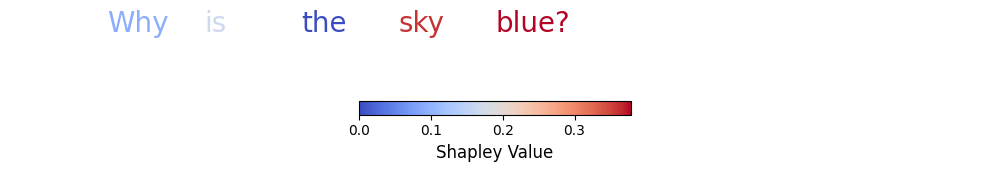

In [7]:
token_shap_openai.plot_colored_text()

And in addition, you can see the raw SHAP values ​​for each token:

In [8]:
token_shap_openai.shapley_values

{'Why_1': np.float64(0.0925151738974352),
 'is_2': np.float64(0.1681673000403178),
 'the_3': np.float64(0.0),
 'sky_4': np.float64(0.36064049685648647),
 'blue?_5': np.float64(0.3786770292057605)}

### Example 2: Code Completion
Prompt: 'Complete the following code: def quick_sort(arr):'

In [9]:
# Define the prompt
prompt = "Complete the following code: def quick_sort(arr):"

# Analyze the prompt
df = token_shap_openai.analyze(prompt, sampling_ratio=0.2, print_highlight_text=True)

Processing combinations:   0%|          | 0/17 [00:00<?, ?it/s]

Complete the following code: def quick_sort(arr): 


### Example 3: Medical Diagnosis

Note: For longer prompts, the analysis might take more time due to the increased number of tokens. therefore in this example I chose to use only the important sample and set the sampling_ratio to 0.

In [10]:
prompt = """
45-year-old male with fatigue, fever, shortness of breath, and chest pain for two weeks. 
Blood tests show high WBC count, and chest X-ray indicates mild lung inflammation. 
Family history: cardiovascular disease, asthma.
Question: What is the most likely diagnosis?
"""

df = token_shap_openai.analyze(prompt, sampling_ratio=0.0, print_highlight_text=True)

Processing combinations:   0%|          | 0/39 [00:00<?, ?it/s]

45-year-old male with fatigue, fever, shortness of breath, and chest pain for two weeks. Blood tests show high WBC count, and chest X-ray indicates mild lung inflammation. Family history: cardiovascular disease, asthma. Question: What is the most likely diagnosis? 


In [12]:
token_shap_openai.print_colored_text()

45-year-old male with fatigue, fever, shortness of breath, and chest pain for two weeks. Blood tests show high WBC count, and chest X-ray indicates mild lung inflammation. Family history: cardiovascular disease, asthma. Question: What is the most likely diagnosis? 


## 3. Using a Local Hugging Face Model

In [13]:
from huggingface_hub import login
login()

In [17]:
model_path = "meta-llama/Llama-3.2-3B-Instruct"
local_model = LocalModel(model_name=model_path)
hf_embedding = HuggingFaceEmbeddings()
splitter = StringSplitter()
token_shap_local = TokenSHAP(model=local_model, splitter=splitter, vectorizer=hf_embedding, debug=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Now we can analyze the prompt:

In [18]:
prompt4 = "What are the symptoms of COVID-19?"
df_local = token_shap_local.analyze(prompt4, sampling_ratio=0.0, print_highlight_text=True)
token_shap_local.print_colored_text()

Number of samples: 6
Number of essential combinations: 6
Number of additional combinations to sample: 0
No additional combinations to sample.
Total combinations to process: 6


Processing combinations:   0%|          | 0/6 [00:00<?, ?it/s]


Processing combination 1/6:
Combination: ['are', 'the', 'symptoms', 'of', 'COVID-19?']
Indexes: (2, 3, 4, 5, 6)
Received response for combination 1

Processing combination 2/6:
Combination: ['What', 'the', 'symptoms', 'of', 'COVID-19?']
Indexes: (1, 3, 4, 5, 6)
Received response for combination 2

Processing combination 3/6:
Combination: ['What', 'are', 'symptoms', 'of', 'COVID-19?']
Indexes: (1, 2, 4, 5, 6)
Received response for combination 3

Processing combination 4/6:
Combination: ['What', 'are', 'the', 'of', 'COVID-19?']
Indexes: (1, 2, 3, 5, 6)
Received response for combination 4

Processing combination 5/6:
Combination: ['What', 'are', 'the', 'symptoms', 'COVID-19?']
Indexes: (1, 2, 3, 4, 6)
Received response for combination 5

Processing combination 6/6:
Combination: ['What', 'are', 'the', 'symptoms', 'of']
Indexes: (1, 2, 3, 4, 5)
Received response for combination 6
What are the symptoms of COVID-19? 
What are the symptoms of COVID-19? 


In [23]:
df_local

,Content,Response,Indexes,Similarity
0,are the symptoms of COVID-19?,The symptoms of COVID-19 can vary from person ...,"(2, 3, 4, 5, 6)",0.831912
1,What the symptoms of COVID-19?,Common symptoms of COVID-19 include:\nCough\nS...,"(1, 3, 4, 5, 6)",0.940392
2,What are symptoms of COVID-19?,Common symptoms include:\nCough\nFatigue\nShor...,"(1, 2, 4, 5, 6)",0.983881
3,What are the of COVID-19?,COVID-19 is a respiratory illness caused by th...,"(1, 2, 3, 5, 6)",0.857867
4,What are the symptoms COVID-19?,"Common symptoms include:\nCough, which may be ...","(1, 2, 3, 4, 6)",0.913982
5,What are the symptoms of,a fungal infection?\nFungal infections can man...,"(1, 2, 3, 4, 5)",0.265348


In [24]:
token_shap_local.highlight_text_background()

What are the symptoms of COVID-19? 


In [25]:
token_shap_local.print_colored_text()

What are the symptoms of COVID-19? 


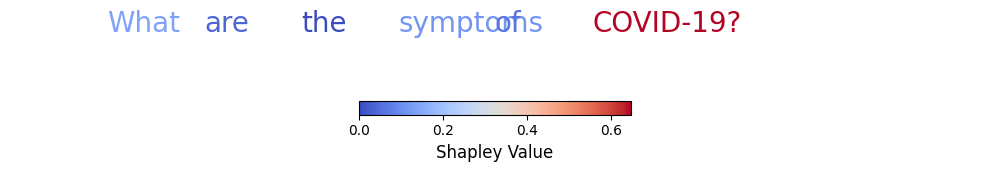

In [26]:
token_shap_local.plot_colored_text()

## 4. Using an Ollama Model

### Setup for API Model
To use an API-based model, you need to use the OllamaModel class.

Through Ollama you can communicate with open source models.

To continue with this section please make sure you have [Ollama](https://ollama.com/) installed.



In [31]:
ollama_model = OllamaModel(model_name="llama3.2-vision:latest", api_url="http://35.95.163.15:11434")
tfidf_embedding = TfidfTextVectorizer()
token_shap_ollama = TokenSHAP(model=ollama_model, splitter=splitter, vectorizer=tfidf_embedding)

In [32]:
prompt5 = "Explain quantum mechanics in simple terms."
df_ollama = token_shap_ollama.analyze(prompt5, sampling_ratio=0.5, print_highlight_text=True)
token_shap_ollama.print_colored_text()

Processing combinations:   0%|          | 0/34 [00:00<?, ?it/s]

Explain quantum mechanics in simple terms. 
Explain quantum mechanics in simple terms. 


## Customizing the Splitter

Sentence-Level Splitting
For more advanced analysis, you might want to split the prompt into sentences rather than words. You can customized the splitter for this purpose.

In [33]:
openai_model = OpenAIModel(api_key=api_key)
openai_embedding = OpenAIEmbeddings(api_key=api_key)
splitter = StringSplitter(split_pattern='\.')
token_shap_openai = TokenSHAP(model=openai_model, splitter=splitter, vectorizer=openai_embedding)

NameError: name 'api_key' is not defined

In [ ]:
prompt = """Our company is experiencing a decline in quarterly sales for the first time in five years.
Recent market trends indicate increased competition from new startups offering similar products at lower prices.
Despite an increase in our online advertising budget, customer engagement on social media platforms has decreased by 15% compared to last quarter.
In addition, feedback from customer surveys suggests that many are dissatisfied with the lack of new features in our products.
Our largest competitor recently launched a new version of their product with innovative functionalities, which seems to have attracted a significant portion of our customer base.
What strategic actions should our company consider to regain market share and improve customer satisfaction?
"""

#### Output Explanation:

The analysis will consider each sentence as a token, allowing you to understand the importance of each sentence in generating the model's response.

In [ ]:
splitter.split(prompt)

In [ ]:
df_sentence = token_shap_openai.analyze(prompt, sampling_ratio=0.5)

In [ ]:
len(df_sentence)

In [ ]:
df_sentence.head()

In [ ]:
token_shap_openai.plot_colored_text(new_line = True)

In [ ]:
token_shap_openai.print_colored_text()

In [ ]:
token_shap_openai.highlight_text_background()

## 6. Conclusion

- We demonstrated how to analyze model responses with TokenSHAP.
- We explored different models: OpenAI API, Local Hugging Face, and Ollama.
- We explored different embedding options and tokenization strategies.
- We optimized performance using sampling ratios.
- We analyzed diverse prompts including scientific, business, and general knowledge questions.
- **We showcased sentence-level splitting, which helps in understanding the importance of entire sentences in longer texts.**

Experiment with different settings to explore TokenSHAP further!